In [11]:
# Standard library imports
import os
import sys
import gzip
import json
import time
from datetime import datetime, timedelta
import ast
import warnings

# Third-party imports
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Local application imports
from config import config

# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import IT and DE data

In [18]:
#Initiate a Spark Session
spark = SparkSession.builder \
    .appName("ParquetReader") \
    .config("spark.driver.memory", "64g") \
    .config("spark.executor.memory", "64g") \
    .getOrCreate()

In [19]:
IT_user = spark.read.parquet("data/python_repositories_filtered_IT.parquet")
DE_user = spark.read.parquet("data/python_repositories_filtered_DE.parquet")

IT_user = IT_user.toPandas()
DE_user = DE_user.toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [22]:
IT_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   actor       1374 non-null   object
 1   created_at  1374 non-null   object
 2   id          1374 non-null   object
 3   org         765 non-null    object
 4   payload     1374 non-null   object
 5   public      1374 non-null   bool  
 6   repo        1374 non-null   object
 7   type        1374 non-null   object
dtypes: bool(1), object(7)
memory usage: 76.6+ KB


In [21]:
DE_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15579 entries, 0 to 15578
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   actor       15579 non-null  object
 1   created_at  15579 non-null  object
 2   id          15579 non-null  object
 3   org         8028 non-null   object
 4   payload     15579 non-null  object
 5   public      15579 non-null  bool  
 6   repo        15579 non-null  object
 7   type        15579 non-null  object
dtypes: bool(1), object(7)
memory usage: 867.3+ KB


In [27]:
# Function to convert Row objects to dictionaries
def convert_row_to_dict(cell):
    if isinstance(cell, Row):
        return cell.asDict()
    return cell

# Apply the function to all cells in the IT and DE DataFrames using apply with map
IT_user = IT_user.apply(lambda col: col.map(convert_row_to_dict))
columns_with_rows = ['actor', 'payload', 'repo']  
for col in columns_with_rows:
    IT_user[col] = IT_user[col].apply(convert_row_to_dict)

DE_user = DE_user.apply(lambda col: col.map(convert_row_to_dict))
columns_with_rows = ['actor', 'payload', 'repo']  
for col in columns_with_rows:
    DE_user[col] = DE_user[col].apply(convert_row_to_dict)

In [28]:
IT_user.head()

,actor,created_at,id,org,payload,public,repo,type
0,{'avatar_url': 'https://avatars.githubusercont...,2023-04-01T05:19:09Z,28133565543,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': '7faaa543daeafbd0e6...",True,"{'id': 288220629, 'name': 'RBniCS/rbnicsprojec...",PushEvent
1,{'avatar_url': 'https://avatars.githubusercont...,2023-04-01T12:05:59Z,28136150697,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': 'bf169f11ce66721c9d...",True,"{'id': 407994039, 'name': 'eagletrt/wiki', 'ur...",PushEvent
2,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02T12:06:10Z,28145193760,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': 'ce6aff334d7a88cc38...",True,"{'id': 407994039, 'name': 'eagletrt/wiki', 'ur...",PushEvent
3,{'avatar_url': 'https://avatars.githubusercont...,2023-04-01T08:53:08Z,28134855255,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': '6a13b751a008f0b479...",True,"{'id': 612556019, 'name': 'liceo-ariosto-spall...",PushEvent
4,{'avatar_url': 'https://avatars.githubusercont...,2023-04-01T06:19:32Z,28133923034,None,"{'action': None, 'before': '1a017ea344a2097c11...",True,"{'id': 543038108, 'name': 'MatteoGuadrini/cloc...",PushEvent


In [29]:
DE_user.head()

,actor,created_at,id,org,payload,public,repo,type
0,{'avatar_url': 'https://avatars.githubusercont...,2023-04-01T15:38:25Z,28137798505,None,"{'action': None, 'before': 'fc04f16b66f3a6227e...",True,"{'id': 616129614, 'name': 'NeffIsBack/wsuks', ...",PushEvent
1,{'avatar_url': 'https://avatars.githubusercont...,2023-04-03T16:18:39Z,28170301198,None,"{'action': None, 'before': '890598b01be92a996a...",True,"{'id': 255672360, 'name': 'anuprulez/galaxy', ...",PushEvent
2,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02T19:36:18Z,28148674921,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': '2a5651d94d46aae422...",True,"{'id': 621365129, 'name': 'hertie-data-science...",PushEvent
3,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02T19:43:48Z,28148725116,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': 'bbd77b5258035d44da...",True,"{'id': 621365129, 'name': 'hertie-data-science...",PushEvent
4,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02T08:59:07Z,28143914551,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': '1c69e44c31373e7897...",True,"{'id': 621365129, 'name': 'hertie-data-science...",PushEvent


In [66]:
commits.iloc[0]['actor']

{'avatar_url': 'https://avatars.githubusercontent.com/u/61382599?',
 'display_login': 'NeffIsBack',
 'gravatar_id': '',
 'id': 61382599,
 'login': 'NeffIsBack',
 'url': 'https://api.github.com/users/NeffIsBack'}

In [26]:
# Grouping by 'type' and sum the numerical columns for an overview of the action types
grouped = DE_IT_commits.groupby('type').count()
grouped

,actor,created_at,id,org,payload,public,repo,repo_name,user,language,full_repo_name,actor_login,Treatment
type,,,,,,,,,,,,,
CommitCommentEvent,14,14,14,10,14,14,14,14,14,14,14,14,14
CreateEvent,1645,1645,1645,478,1645,1645,1645,1645,1645,1645,1645,1645,1645
DeleteEvent,975,975,975,537,975,975,975,975,975,975,975,975,975
ForkEvent,286,286,286,139,286,286,286,286,286,286,286,286,286
GollumEvent,61,61,61,20,61,61,61,61,61,61,61,61,61
IssueCommentEvent,2024,2024,2024,1293,2024,2024,2024,2024,2024,2024,2024,2024,2024
IssuesEvent,845,845,845,514,845,845,845,845,845,845,845,845,845
MemberEvent,47,47,47,20,47,47,47,47,47,47,47,47,47
PublicEvent,45,45,45,0,45,45,45,45,45,45,45,45,45


# Data Preprocessing
1. Add Treatment variable: 1 = DE (Treatment) and 0 = IT (Control)
2. Merge DE and IT into one dataframe 'Commits'
3. Add 'time_id': indicates the day and hour of each commit, for analysis on hourly-level (less granular than original created_at, which was down to minutes, to be adjusted to daily level if we decide to look at longer timeframes)
4. Add 'period': 1 = pre (pre-Treatment, i.e pre GPT introduction), 0 = post (post-Treatment, i.e post GPT introduction)
5. Count rows with missing values in 'id', 'actor', 'repo', 'created_at'

In [76]:
# 1. Add 'Treatment'
DE_user['treatment'] = 1
IT_user['treatment'] = 0

# 2. Concatenate DE/IT DataFrames
commits = pd.concat([DE_user, IT_user])

# 3. Add 'time_id' column
commits['created_at'] = pd.to_datetime(commits['created_at']).dt.tz_localize(None)
commits['time_id'] = commits['created_at'].dt.strftime('%Y-%m-%d %H:00')

# 4. Add 'period', define date ranges for pre and post 
pre = ('2023-03-24', '2023-03-30')
post = ('2023-04-01', '2023-04-07')

pre = [pd.to_datetime(date) for date in pre]
post = [pd.to_datetime(date) for date in post]

commits['period'] = commits['created_at'].apply(
    lambda x: 0 if pre[0] <= x <= pre[1] else (1 if post[0] <= x <= post[1] else None)
)

# 5. Check for missing values
rows_with_missing_values = commits[commits[['id', 'actor', 'repo', 'created_at']].isnull().any(axis=1)]
missing_count = len(rows_with_missing_values)
print(f"Number of rows with missing values: {missing_count}")

commits.to_csv('data/commits_all.csv', index=False)

Number of rows with missing values: 0


In [77]:
commits.head()

,actor,created_at,id,org,payload,public,repo,type,Treatment,treatment,time_id,period
0,{'avatar_url': 'https://avatars.githubusercont...,2023-04-01 15:38:25,28137798505,None,"{'action': None, 'before': 'fc04f16b66f3a6227e...",True,"{'id': 616129614, 'name': 'NeffIsBack/wsuks', ...",PushEvent,1,1,2023-04-01 15:00,1
1,{'avatar_url': 'https://avatars.githubusercont...,2023-04-03 16:18:39,28170301198,None,"{'action': None, 'before': '890598b01be92a996a...",True,"{'id': 255672360, 'name': 'anuprulez/galaxy', ...",PushEvent,1,1,2023-04-03 16:00,1
2,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02 19:36:18,28148674921,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': '2a5651d94d46aae422...",True,"{'id': 621365129, 'name': 'hertie-data-science...",PushEvent,1,1,2023-04-02 19:00,1
3,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02 19:43:48,28148725116,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': 'bbd77b5258035d44da...",True,"{'id': 621365129, 'name': 'hertie-data-science...",PushEvent,1,1,2023-04-02 19:00,1
4,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02 08:59:07,28143914551,{'avatar_url': 'https://avatars.githubusercont...,"{'action': None, 'before': '1c69e44c31373e7897...",True,"{'id': 621365129, 'name': 'hertie-data-science...",PushEvent,1,1,2023-04-02 08:00,1


# Variable construction
1. Extract needed info from nested dictionaries and add them as separate columns
2. Add one column per event type, with either 1 = True or 0 = False (e.g. a row (commit) that has the event type 'Fork', will have the value 1 in column 'is_forkevent' and 0 in each other event type column.
3. Create the 'panel' dataframe which only includes the needed columns for the DiD


In [137]:
# 1. Extracting relevant columns from nested dictionaries in commits df
commits['actor_login'] = commits['actor'].apply(lambda x: x.get('login') if isinstance(x, dict) else np.nan)
commits['actor_id'] = commits['actor'].apply(lambda x: x.get('id') if isinstance(x, dict) else np.nan)
commits['repo_name'] = commits['repo'].apply(lambda x: x.get('name') if isinstance(x, dict) else np.nan)
commits['repo_id'] = commits['repo'].apply(lambda x: x.get('id') if isinstance(x, dict) else np.nan)

# 2. Add one column per event type, 1 = True, 0 = False
event_types = [
    'CommitCommentEvent', 'ForkEvent', 'IssuesEvent', 'IssueCommentEvent', 
    'PullRequestEvent', 'PullRequestReviewCommentEvent', 'PushEvent', 'WatchEvent']

for event in event_types:
    column_name = f'is_{event.lower()}'
    commits[column_name] = (commits['type'] == event).astype(int)

# 3. Selecting the required columns and construct the panel df
required_columns = [
   # "actor_login",  
    "actor_id",  
   # "repo_name",  
    "repo_id", 
    "treatment",
    "period",
    "time_id"
]

event_types = [
    "is_pushevent", 
    "is_pullrequestevent",
    "is_issuesevent",
    "is_forkevent",
    "is_watchevent",
    "is_commitcommentevent", 
    "is_issuecommentevent",
    "is_pullrequestreviewcommentevent"
]

columns_to_keep = required_columns + event_types
panel_commits = commits[columns_to_keep].copy()

# Adding a new column 'collaboration' which is the sum of all event type counts and add it as a column next to time_id
collaboration = panel_commits[event_types].sum(axis=1)
idx = panel_commits.columns.get_loc('time_id') + 1
panel_commits.insert(loc=idx, column='collaboration', value=collaboration)

In [138]:
panel_commits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16953 entries, 0 to 1373
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   actor_id                          16953 non-null  int64 
 1   repo_id                           16953 non-null  int64 
 2   treatment                         16953 non-null  int64 
 3   period                            16953 non-null  int64 
 4   time_id                           16953 non-null  object
 5   collaboration                     16953 non-null  int64 
 6   is_pushevent                      16953 non-null  int64 
 7   is_pullrequestevent               16953 non-null  int64 
 8   is_issuesevent                    16953 non-null  int64 
 9   is_forkevent                      16953 non-null  int64 
 10  is_watchevent                     16953 non-null  int64 
 11  is_commitcommentevent             16953 non-null  int64 
 12  is_issuecommentevent    

# Aggregation by repository and hour 
1. Grouping panel_commits df by 'repo_id' and 'time_id', summing up event type counts
2. num_actors: Number of unique contributors per repo per hour
3. num_commits: Number of commits per repo per hour (important: is not necessarily equal to the sum of event types displayed in the table, as there are event types which are not considered for the collaboration variable and number of commits simply counts all commits in an hour, irrespective of their event type)

In [143]:
# Define the aggregation functions
aggregations = {
    'actor_id': 'nunique',  # count unique actors
    'treatment': 'first',  # since all values are the same within a group, we use 'first'
    'period': 'first',  
    'collaboration': 'sum',
    'is_pushevent': 'sum',
    'is_pullrequestevent': 'sum',
    'is_issuesevent': 'sum',
    'is_forkevent': 'sum',
    'is_watchevent': 'sum',
    'is_commitcommentevent': 'sum',
    'is_issuecommentevent': 'sum',
    'is_pullrequestreviewcommentevent': 'sum'
}

# Perform the groupby operation and aggregate
panel = panel_commits.groupby(['repo_id', 'time_id']).agg(aggregations).reset_index()

# Rename 'actor_id' to 'num_actors' for clarity
panel.rename(columns={'actor_id': 'num_actors'}, inplace=True)

# Adding the number of commits as the size of each group
panel['num_commits'] = panel_commits.groupby(['repo_id', 'time_id']).size().reset_index(name='num_commits')['num_commits']

# Save the resulting DataFrame to a CSV file
panel.to_csv('grouped_panel_collaboration.csv', index=False)

In [144]:
panel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5119 entries, 0 to 5118
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   repo_id                           5119 non-null   int64 
 1   time_id                           5119 non-null   object
 2   num_actors                        5119 non-null   int64 
 3   treatment                         5119 non-null   int64 
 4   period                            5119 non-null   int64 
 5   collaboration                     5119 non-null   int64 
 6   is_pushevent                      5119 non-null   int64 
 7   is_pullrequestevent               5119 non-null   int64 
 8   is_issuesevent                    5119 non-null   int64 
 9   is_forkevent                      5119 non-null   int64 
 10  is_watchevent                     5119 non-null   int64 
 11  is_commitcommentevent             5119 non-null   int64 
 12  is_issuecommentevent

In [145]:
panel.head()

,repo_id,time_id,num_actors,treatment,period,collaboration,is_pushevent,is_pullrequestevent,is_issuesevent,is_forkevent,is_watchevent,is_commitcommentevent,is_issuecommentevent,is_pullrequestreviewcommentevent,num_commits
0,185386,2023-04-01 09:00,1,1,1,1,1,0,0,0,0,0,0,0,1
1,185386,2023-04-02 21:00,1,1,1,1,1,0,0,0,0,0,0,0,1
2,432305,2023-04-01 10:00,1,1,1,3,2,1,0,0,0,0,0,0,4
3,432305,2023-04-02 18:00,1,1,1,1,1,0,0,0,0,0,0,0,1
4,432305,2023-04-03 18:00,1,1,1,4,1,1,0,0,0,0,2,0,5


In [146]:
panel.describe()

,repo_id,num_actors,treatment,period,collaboration,is_pushevent,is_pullrequestevent,is_issuesevent,is_forkevent,is_watchevent,is_commitcommentevent,is_issuecommentevent,is_pullrequestreviewcommentevent,num_commits
count,5.119000e+03,5119.000000,5119.000000,5119.0,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000
mean,4.025000e+08,1.686462,0.886501,1.0,2.776910,1.299473,0.282477,0.134792,0.061731,0.424497,0.002540,0.413362,0.158039,3.311780
std,2.135019e+08,3.044023,0.317232,0.0,4.350716,1.576616,0.885330,0.547650,0.340819,2.363283,0.066989,1.476356,0.973380,5.183095
min,1.853860e+05,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.101867e+08,1.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,4.707272e+08,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,6.056138e+08,1.000000,1.000000,1.0,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,6.231802e+08,47.000000,1.000000,1.0,51.000000,34.000000,15.000000,12.000000,5.000000,40.000000,3.000000,25.000000,19.000000,65.000000


# Visualize Distribution of Collaboration Variable and individual event types

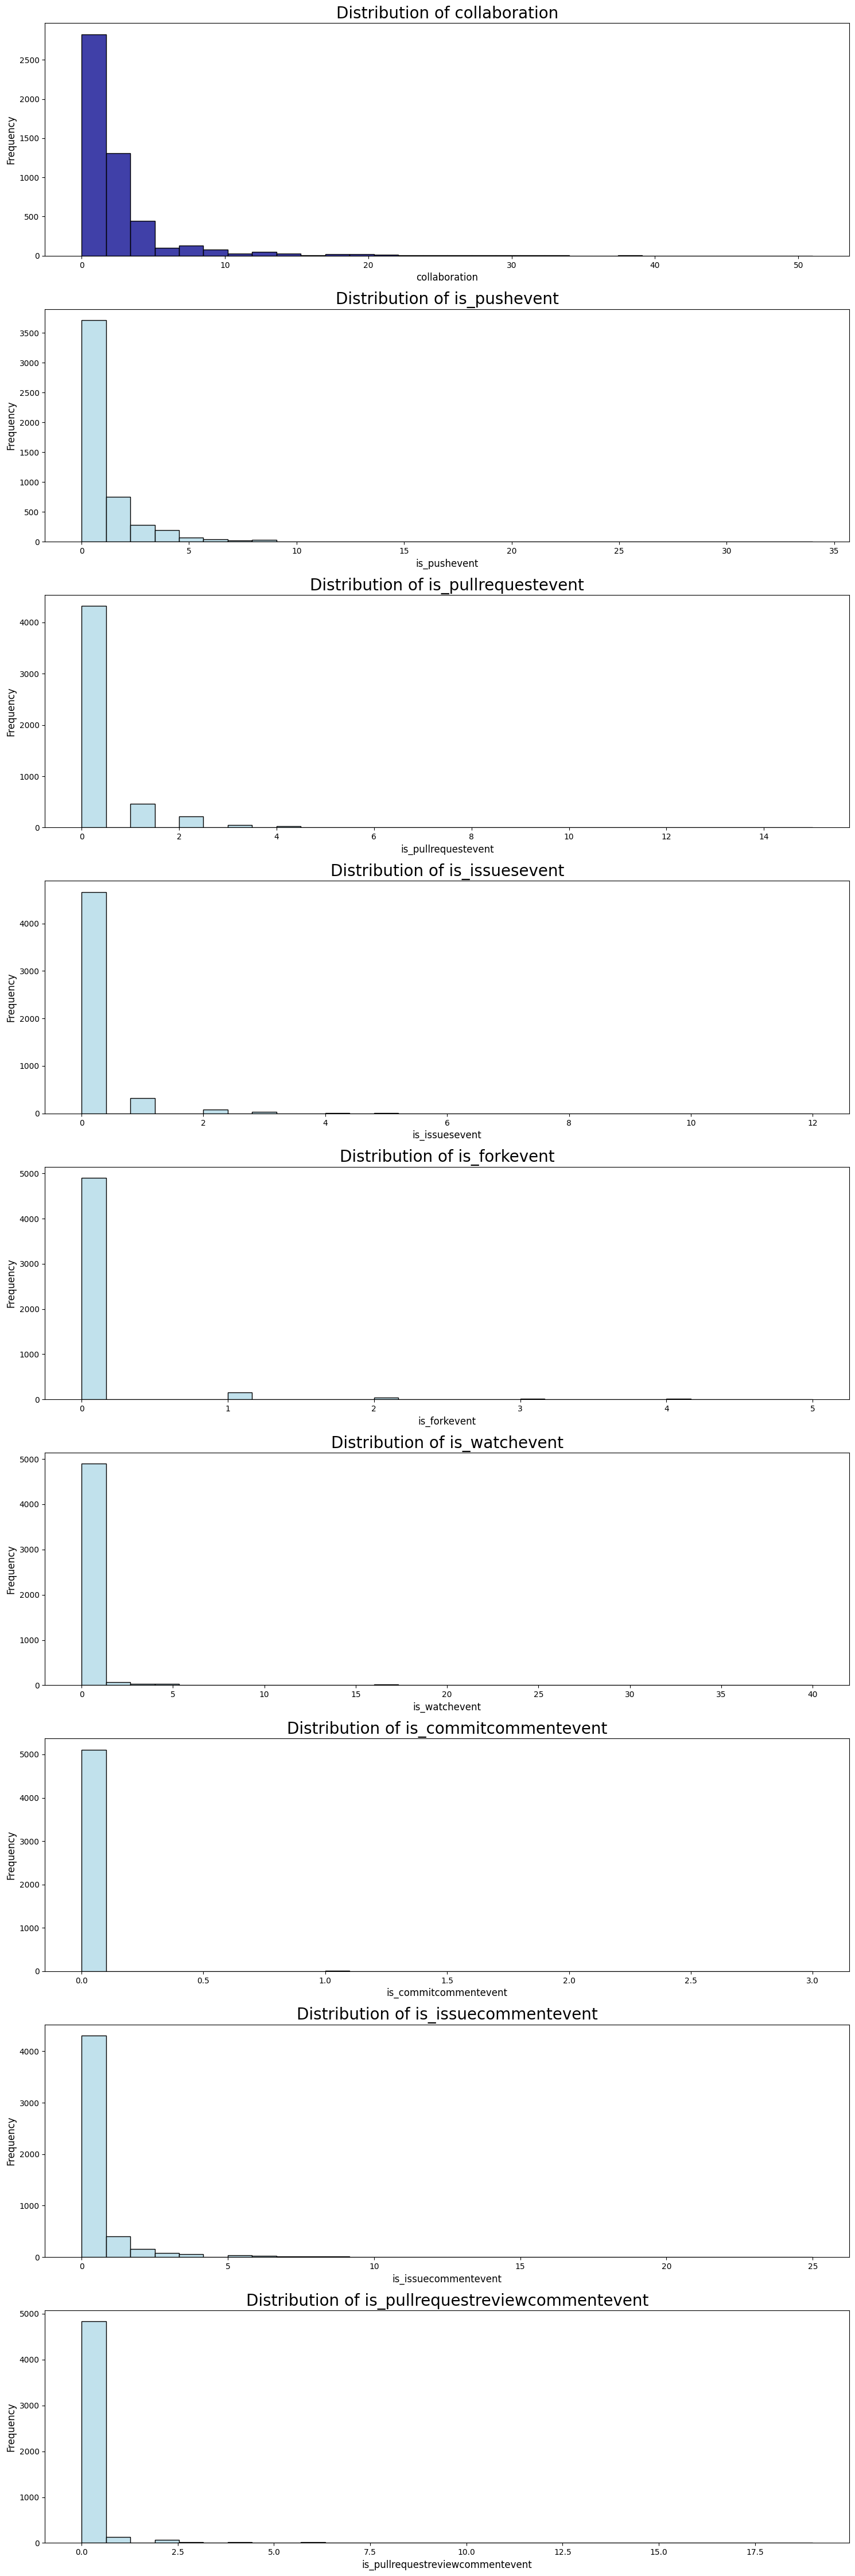

In [148]:
event_types = [
    'collaboration',
    'is_pushevent', 'is_pullrequestevent', 'is_issuesevent', 'is_forkevent', 
    'is_watchevent', 'is_commitcommentevent', 'is_issuecommentevent', 
    'is_pullrequestreviewcommentevent'
]

# Number of rows and columns for the subplot grid
n_rows = len(event_types)
n_cols = 1  # one column, each row will contain one plot

# Initialize a figure for the plots with multiple subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust the size as needed, particularly the height

# Flatten the axes array, for easy iteration, and ensure it's a list for consistent handling
axes = axes.flatten() if n_rows > 1 else [axes]

# Iterate over all event types
for i, event in enumerate(event_types):
    color = 'darkblue' if event == 'collaboration' else 'lightblue'  # choose color based on the variable
    sns.histplot(data=panel, x=event, ax=axes[i], bins=30, color=color, kde=False)  # plot the histogram

    # Set title, labels, and aesthetics for each subplot
    axes[i].set_title(f'Distribution of {event}', fontsize=20)
    axes[i].set_xlabel(event, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Apply tight layout and show the plot
plt.tight_layout()
plt.show()


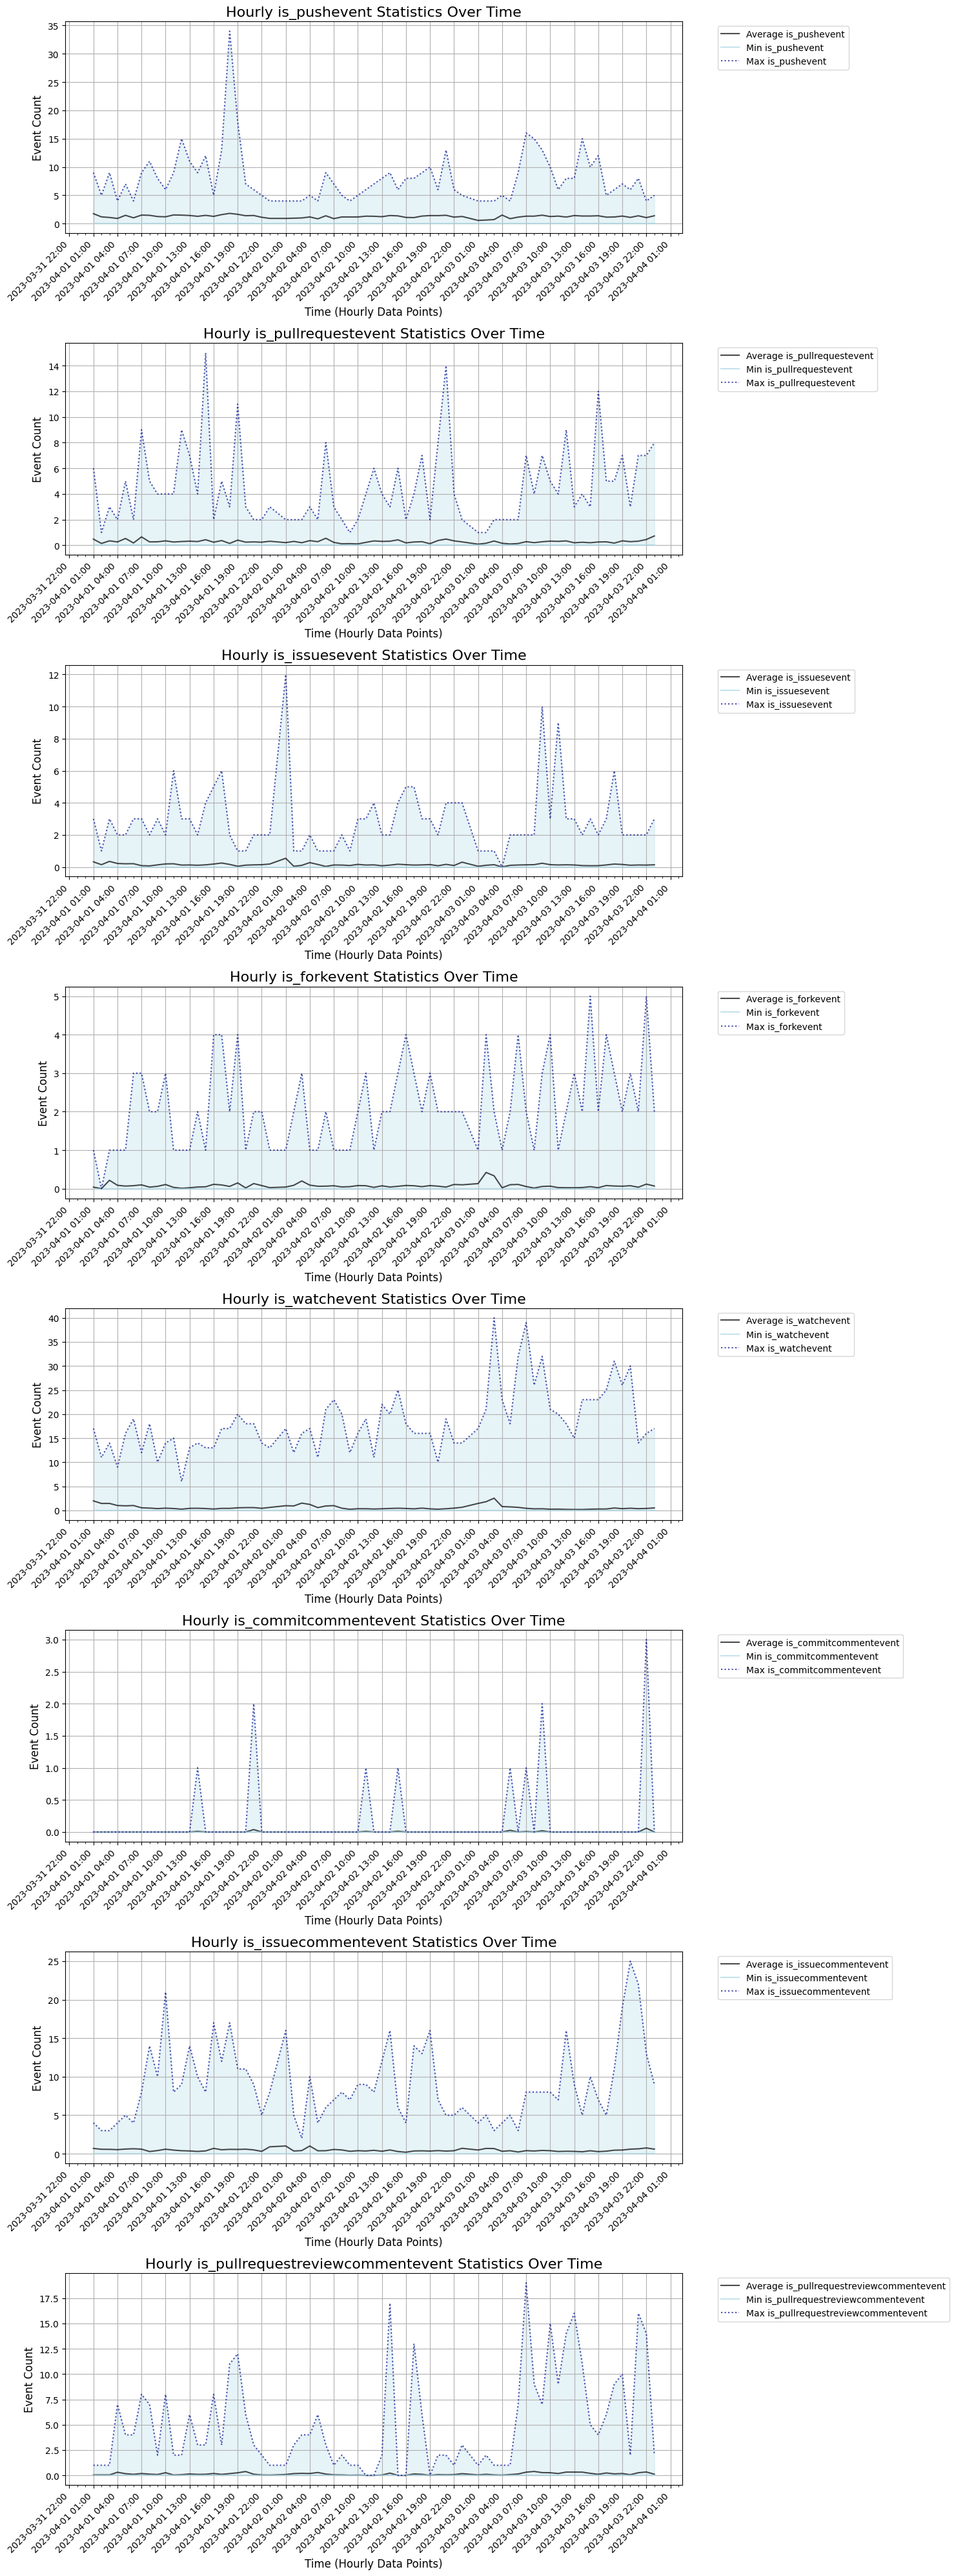

In [129]:
import matplotlib.dates as mdates
# Number of rows for the subplot grid
n_rows = len(event_types)

# Initialize a figure for the plots with multiple subplots
fig, axes = plt.subplots(n_rows, 1, figsize=(15, 5 * n_rows))  # Adjust the size as needed, particularly the height

# Flatten the axes array, for easy iteration, and ensure it's a list for consistent handling
axes = axes.flatten() if n_rows > 1 else [axes]

# Iterate over all event types
for i, event in enumerate(event_types):
    # Group by 'time_id' and calculate average, min, and max for each event type
    event_stats = panel.groupby('time_id')[event].agg(['mean', 'min', 'max']).reset_index()

    # Plotting the average number of events
    axes[i].plot(event_stats['time_id'], event_stats['mean'], color='black', marker='', linestyle='-', label=f'Average {event}', alpha=0.7)

    # Plotting min and max with specified color and style
    axes[i].plot(event_stats['time_id'], event_stats['min'], color='lightblue', marker='', linestyle='-', label=f'Min {event}', alpha=0.7)
    axes[i].plot(event_stats['time_id'], event_stats['max'], color='darkblue', marker='', linestyle=':', label=f'Max {event}', alpha=0.7)  # Dotted line

    # Fill the area between min and max
    axes[i].fill_between(event_stats['time_id'], event_stats['min'], event_stats['max'], color='lightblue', alpha=0.3)

    # Set title, labels, and legend for each subplot
    axes[i].set_title(f'Hourly {event} Statistics Over Time', fontsize=16)  # Bigger title
    axes[i].set_xlabel('Time (Hourly Data Points)', fontsize=12)  # Explanation for the x-axis
    axes[i].set_ylabel('Event Count', fontsize=12)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Place legend to the right of the plot
    axes[i].grid(True)

    # Formatting the x-axis to display dates more clearly
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format as "YYYY-MM-DD HH:MM"
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')  # Rotate date labels for better readability

    # Adjust x-axis visibility for clarity
    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Set major ticks every 4 hours
    axes[i].xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Set minor ticks every hour

# Apply tight layout and show the plot
plt.tight_layout()
plt.show()

# Parallel Trends Assumption

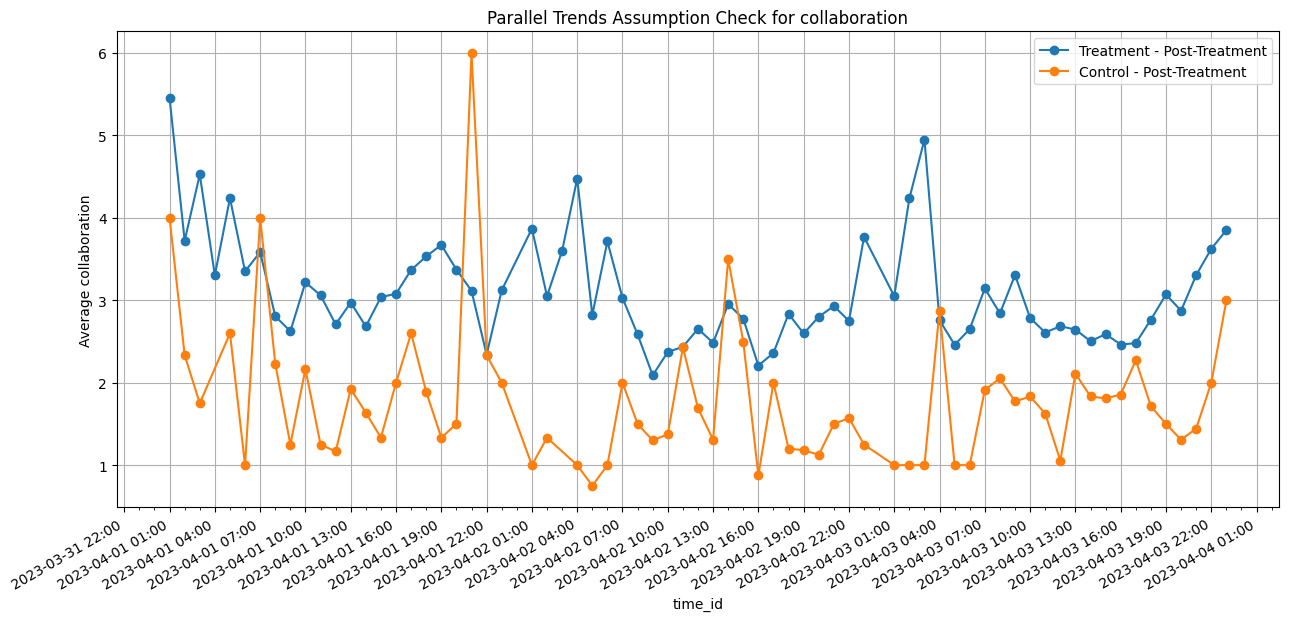

In [159]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Import for date formatting

def check_parallel_trends(panel_data, outcome_var, time_var, treatment_var, period_var):
    """
    Function to plot the trends of the outcome variable for treatment and control groups.
    
    Args:
    panel_data (DataFrame): The panel data containing all observations.
    outcome_var (str): The name of the outcome variable to check for parallel trends.
    time_var (str): Name of the time variable in the panel data.
    treatment_var (str): Name of the treatment indicator variable.
    period_var (str): Name of the period indicator variable (0 for pre-treatment, 1 for post-treatment).
    """
    # Ensure data is sorted by time
    panel_data = panel_data.sort_values(by=[time_var])
    
    plt.figure(figsize=(15, 7))
    
    # Loop through each level of treatment (0 and 1)
    for treatment in panel_data[treatment_var].unique():
        # Subset the data for the treatment and control groups
        subset = panel_data[panel_data[treatment_var] == treatment]
        
        # Aggregate data by time period
        agg_data = subset.groupby([time_var, period_var]).agg({outcome_var: 'mean'}).reset_index()
        
        # Plotting
        for period in agg_data[period_var].unique():
            period_data = agg_data[agg_data[period_var] == period]
            label = f"{'Control' if treatment == 0 else 'Treatment'} - {'Pre-Treatment' if period == 0 else 'Post-Treatment'}"
            plt.plot(period_data[time_var], period_data[outcome_var], marker='o', linestyle='-', label=label)
    
    plt.title(f'Parallel Trends Assumption Check for {outcome_var}')
    plt.xlabel(time_var)
    plt.ylabel(f'Average {outcome_var}')
    plt.legend()
    plt.grid(True)

    # Handle the x-axis date formatting and tick settings
    ax = plt.gca()  # get the current axes

    # Instead of setting a tick every 15 minutes, we can set a major tick every few hours (adjust as needed)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))  # e.g., place a major tick every 3 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Format as "YYYY-MM-DD HH:MM"

    # Optional: for more granularity, you can set minor ticks every hour or adjust as suits your data's span
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # e.g., place a minor tick every 1 hour

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate date labels for better readability

    # Rotate date labels automatically for better readability
    plt.gcf().autofmt_xdate()

    plt.show()

# Specify the variable for collaboration
outcome_variable = 'collaboration'  # This is the metric you're evaluating
time_variable = 'time_id'
treatment_variable = 'treatment'
period_variable = 'period'

# Call the function with your panel data
check_parallel_trends(panel, outcome_variable, time_variable, treatment_variable, period_variable)


### Interpretation - what to look out for when looking at the graphs (once we use the full dataset)
- Pre-Treatment Trends: The lines for Italy and Germany should move in parallel, showing a similar trajectory
- Divergence Post-Treatment: If the treatment had an effect, the two lines might diverge post GPT
- Consistency Across Metrics: If the same trend is consistent across all metrics, there is stronger validation for the assumption

# Calculate DiD Estimates & Fit Regressions

In [160]:
import statsmodels.formula.api as smf

pd.options.mode.chained_assignment = None  # Disable warnings

# Step 1: Check and convert data types if necessary
print("Current data types:\n", panel['collaboration'].dtype, "\n")

# Step 2: Check for and handle missing or infinite values
panel = panel.replace([np.inf, -np.inf], np.nan)

# Option 1: Drop NaN values
# panel = panel.dropna(subset=['collaboration'])

# Option 2: Fill NaN values with a placeholder like 0 or the mean (uncomment the option you prefer)
# panel['collaboration'] = panel['collaboration'].fillna(0)
panel['collaboration'] = panel['collaboration'].fillna(panel['collaboration'].mean())

# Now convert 'Collaboration' to integer type
panel['collaboration'] = panel['collaboration'].astype(int)

# Step 3: Convert 'period' to numeric if it's categorical
if panel['period'].dtype == object:
    panel['period'] = panel['period'].map({'pre': 0, 'post': 1})

# Step 4: Avoid SettingWithCopyWarning by using .loc for new column creation
panel.loc[:, 'treat_post'] = panel['treatment'] * panel['period']

# Step 5: Re-run the regression model for 'Collaboration'
try:
    model = smf.ols('collaboration ~ treatment + period + treat_post', data=panel).fit()
    print("Results for Collaboration:\n", model.summary(), "\n---\n")
except Exception as e:
    print(f"An error occurred while processing the model for Collaboration: {str(e)}\n---\n")

pd.options.mode.chained_assignment = 'warn'  # Reset to the default warning behavior

Current data types:
 int64 

Results for Collaboration:
                             OLS Regression Results                            
Dep. Variable:          collaboration   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     14.63
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           4.60e-07
Time:                        11:57:32   Log-Likelihood:                -14775.
No. Observations:                5119   AIC:                         2.956e+04
Df Residuals:                    5116   BIC:                         2.958e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------